In [27]:
import numpy
import scipy.special
import scipy.ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
class neuralNetwork:
    
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # задать количество узлов во входном, скрытом и выходном слоях
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # коэффициент обучения
        self.lr = learningrate
        
        # матрицы весовых коэффициентов связей
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # использование сигмоиды в качестве функции активации
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        pass
    
    def train(self, inputs_list, targets_list):
        # Преобразовать список входных значений
        # в двумерный массив
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # рассчитать входные сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        # рассчитать исходящие сигналы для скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # расчитать исходящие сигналы для выходного слоя
        final_outputs = self.activation_function(final_inputs)
        
        targets = numpy.array(targets_list, ndmin=2).T
        
        # ошибка = целевое значение - фактическое значение
        output_errors = targets - final_outputs
        
        # ошибки скрытого слоя - это ошибки output_errors
        # распределенные пропорционально весовым коэффициентам связей
        # и рекомбинированные на скрытых узлах
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # обновить весовые коэффициенты связей между входным и скрытым слоями
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)),
                                        numpy.transpose(inputs))
        
        # обновить весовые коэффициенты связей между скрытым и выходным слоями
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)),
                                        numpy.transpose(hidden_outputs))
        pass
    
    def query(self, inputs_list):
        # Преобразовать список входных значений
        # в двумерный массив
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # рассчитать входные сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        # рассчитать исходящие сигналы для скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # расчитать исходящие сигналы для выходного слоя
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
    # обратное действие нейронной сети
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [29]:
input_nodes = 784
hidden_nodes = 150
output_nodes = 10

learning_rate = 0.2

n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# загрузить в список тестовый набор CSV-файла набора MNIST
training_data_file = open('mnist_dataset/mnist_train.csv', 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [30]:
%%time
# ТРЕНИРОВКА
epochs = 5
for e in range(epochs):
    for record in training_data_list:
        # получить список значений, используя символы запятой в качестве разделителя
        all_values = record.split(',')

        # масштабировать и сместить входные значения
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

        # создать целевые значения
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        # rotated clockwise by x degrees
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)
        
        pass
    pass

Wall time: 9min 53s


In [31]:
test_data_file = open('mnist_dataset/mnist_test.csv', 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [32]:
scorecard = []

In [33]:
for record in test_data_list:
    all_values = record.split(',')
    
    correct_label = int(all_values[0])
    
    inputs = (numpy.asfarray(all_values[1:]) / 155.0 * 0.99) + 0.01
    
    outputs = n.query(inputs)
    
    label = numpy.argmax(outputs)
    
    if label == correct_label:
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass
    
    pass

In [34]:
scorecard_array = numpy.asarray(scorecard)
efficiency = scorecard_array.sum() / scorecard_array.size
print('Эффективность: {:.2%}'.format(scorecard_array.sum() / scorecard_array.size))

Эффективность: 95.56%


[0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]


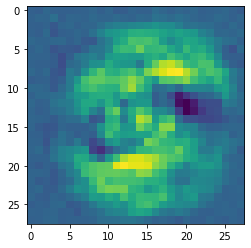

In [35]:
# label to test
label = 5
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
plt.imshow(image_data.reshape(28,28), interpolation='None')